In [338]:
! pip install numpy pandas matplotlib seaborn scikit-learn 

In [298]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

## Custom Logistic Regression Class

In [300]:
# custom logistic regression class
class MyLogisticRegression:

    def __init__(self, n_features, lr=0.1, n_iters=1000, threshold=0):
        self.n_features = n_features
        self.lr = lr
        self.n_iters = n_iters
        self.weights = np.random.randn(n_features+1)
        self.threshold = threshold 

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _cost(self, X, y):
        y_pred = self._sigmoid(X @ self.weights)
        cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)
        return cost

    def _gradient(self, X, y):
        y_pred = self._sigmoid(X @ self.weights)
        gradient = X.T @ (y_pred - y) / len(y)
        return gradient

    def fit(self, X, y):
        X_df = pd.DataFrame(X)  # Convert numpy array to DataFrame
        correlations = X_df.corrwith(pd.Series(y))  # Calculate correlation with y
        self.selected_features = correlations.abs().nlargest(self.n_features).index
        X = X[:, self.selected_features]

        # Adding the bias coloumn
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

        for i in range(self.n_iters):
            self.weights -= self.lr * self._gradient(X, y)
            loss = self._cost(X, y).mean()
            # terminate early if loss is less than threshold
            if loss < self.threshold:
                break


    def predict(self, X):

        if self.selected_features is None:
            raise Exception("Model is not trained yet. Please call fit method first.")

        # select the features
        X = X[:, self.selected_features]
        
        # Add column for bias
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

        y_pred = self._sigmoid(X @ self.weights)
        y_pred = np.round(y_pred).astype(int)
        return y_pred
        

## Custom Bagging Classifier

In [301]:
# creating a class for bagging classifier using MyLogisticRegression
class MyBaggingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
    
    def predict(self, X):
        y_preds = []
        # iterate through each model
        for model in self.models:
            # predict the output using the model
            y_pred = model.predict(X)
            y_preds.append(y_pred)
        return y_preds


## Custom Voting Classifier

In [302]:
# creating a class for bagging classifier using MyLogisticRegression
class MyVotingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)

    def predict(self, X):
        y_preds = []
        for model in self.models:
            y_pred = model.predict(X)
            y_preds.append(y_pred)
        y_preds = np.array(y_preds)
        return np.round(np.mean(y_preds, axis=0)).astype(int)
    

## Custom Stacking Class

In [303]:
#creating a class for stacking classifier using MyLogisticRegression
class MyStackingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        # split the data into training and validation set
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
            model.fit(X_train[indices], y_train[indices])
            self.models.append(model)

        X_pred = np.zeros((X_val.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            X_pred[:, i] = model.predict(X_val) 

        # adding the features of X to X_train
        X_val = np.concatenate([X_val, X_pred], axis=1)

        # meta model predicts by both previous features and base model predictions
        self.meta_model = MyLogisticRegression(n_features=min(50, X_val.shape[1]), threshold=self.threshold)
        self.meta_model.fit(X_val, y_val)

    def predict(self, X):
        X_test = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            X_test[:, i] = model.predict(X)
        X_test = np.concatenate([X, X_test], axis=1)
        return self.meta_model.predict(X_test)

## Testing Metrics

In [304]:
from sklearn.metrics import roc_auc_score, average_precision_score

# create custom metrics functions
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def sensitivity(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_true)

def specificity(y_true, y_pred):
    return np.sum((1 - y_true) * (1 - y_pred)) / np.sum(1 - y_true)

def precision(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_pred)

def recall(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_true)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)

def aupr(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

In [305]:
def report(y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    prec = precision(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auroc_val = auroc(y_true, y_pred)
    aupr_val = aupr(y_true, y_pred)
    
    # print the metrics with 4 decimal places after the point
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity: {sens:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUROC: {auroc_val:.4f}")
    print(f"AUPR: {aupr_val:.4f}")

In [306]:
def get_scores(y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    prec = precision(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auroc_val = auroc(y_true, y_pred)
    aupr_val = aupr(y_true, y_pred)
    
    return acc, sens, spec, prec, f1, auroc_val, aupr_val

## Preprocessing Dataset 1

In [333]:
csv_path = 'datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(csv_path)

df.head()
df.info()
# finding missing values
print(df.isnull().sum())
# find duplicate rows
print('Duplicate Rows : ', df.duplicated().sum())

# convert total charges to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.info()

# Assuming df is your DataFrame
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

# drop customerID
df.drop('customerID', axis=1, inplace=True)

# printing the unique values of a coloumn with data type object
columns = df.columns
for column in columns:
    if df[column].dtype == 'object':
        print(column, df[column].unique())


# converting object data type to category
for column in columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

df.info()

# preprocess data
for column in columns:
    if df[column].dtype == 'category' and column != 'Churn':
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)

# mapping the target variable to 0 and 1
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# convert the target variable to int
df['Churn'] = df['Churn'].astype(int)

df.head()

# df.dropna(inplace=True)

# churn is the target
X = df.drop(['Churn'], axis=1).values
y = df['Churn'].values

# split the data into 80% training and 20% testing using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit to the training data
X_train = sc.fit_transform(X_train)
# transform the testing data
X_test = sc.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Preprocessing Dataset 2

In [336]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
'hours-per-week', 'native-country', 'income']

train_df = pd.read_csv('datasets/adult/adult.data', names = columns)
test_df = pd.read_csv('datasets/adult/adult.test', names = columns, skiprows=1)

train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

# finding missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

train_df.head()
train_df.info()
test_df.info()

# printing the count of unique values of each column if coloumn datatype is object
for column in columns:
    if train_df[column].dtype == 'object':
        print(column, train_df[column].unique())

# printing the count of unique values of each column if coloumn datatype is object
for column in columns:
    if test_df[column].dtype == 'object':
        print(column, test_df[column].unique())

test_df['income'] = test_df['income'].str.replace(".", "")
# test_df['income'].unique()

df = pd.concat([train_df, test_df])

df['education'].unique()

df['education-num'].unique()
df.drop('education', axis=1, inplace=True)

df.info()
df['income'].unique()

# mapping the income to 0 or 1 
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
df['income'].unique()
df.info()

columns = df.columns
for column in columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

df.info()

# adding dummies for the category columns
columns = df.columns
for column in columns:
    if df[column].dtype == 'category':
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)

df.head()
df.shape
df['income'].unique()

# splittng the first train_df.shape[0] rows as train data and rest as test data
train_df = df.iloc[:train_df.shape[0]]
test_df = df.iloc[train_df.shape[0]:]

X_train = train_df.drop(['income'], axis=1).values
y_train = train_df['income'].values

X_test = test_df.drop(['income'], axis=1).values
y_test = test_df['income'].values


# scale the data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit to the training data
X_train = sc.fit_transform(X_train)
# transform the testing data
X_test = sc.transform(X_test)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   e

## Preprocessing Dataset 3

In [339]:
# read credit dataset from datasets/creditcard.csv
df = pd.read_csv('datasets/creditcard.csv')
df.info()

df.head()

# finding missing values
print('Missing Values : ', df.isnull().sum())

# finding duplicate rows
print('Duplicate Rows : ',df.duplicated().sum())

# drop duplicate rows
df.drop_duplicates(inplace=True)

# print unique values from each coloumn if datatype is object
for column in df.columns:
    if df[column].dtype == 'object':
        print(column, df[column].unique())

# take all the rows with class 1
one_df = df[df['Class'] == 1]

# take 20000 rows with class 0
zero_df = df[df['Class'] == 0].sample(20000)

df = pd.concat([one_df, zero_df])

# fit to the training data
X = df.drop(['Class'], axis=1).values

# transform the testing data
X = sc.fit_transform(X)

y = df['Class'].values

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# scale the data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# fit to the training data
X_train = sc.fit_transform(X_train)
# transform the testing data
X_test = sc.transform(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Testing Any Dataset

Testing with Bagging Classifier


/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: divide by zero encountered in log
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)
/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: invalid value encountered in multiply
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)


accuracy: 0.9948 +- 0.0003
sensitivity: 0.7959 +- 0.0100
specificity: 0.9993 +- 0.0003
precision: 0.9652 +- 0.0157
f1: 0.8723 +- 0.0071
auroc: 0.8976 +- 0.0049
aupr: 0.7727 +- 0.0128


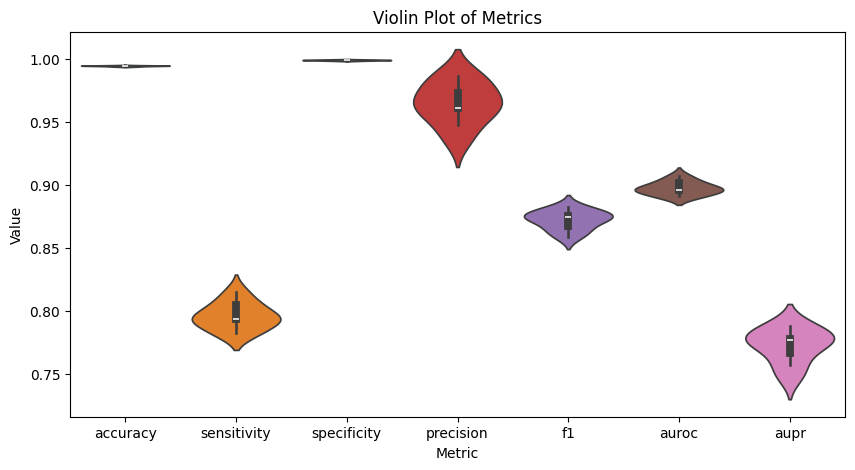

Testing with Voting Classifier


/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: divide by zero encountered in log
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)
/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: invalid value encountered in multiply
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)


Accuracy: 0.9954
Sensitivity: 0.8043
Specificity: 0.9998
Precision: 0.9867
F1: 0.8862
AUROC: 0.9020
AUPR: 0.7980
Testing with Stacking Classifier


/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: divide by zero encountered in log
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)
/tmp/ipykernel_15194/2149573108.py:16: RuntimeWarning: invalid value encountered in multiply
  cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)


Accuracy: 0.9944
Sensitivity: 0.8043
Specificity: 0.9988
Precision: 0.9367
F1: 0.8655
AUROC: 0.9015
AUPR: 0.7578


In [340]:
# Testing with Bagging Classifier
print("Testing with Bagging Classifier")
model = MyBaggingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

metrics = {
    'accuracy': [],
    'sensitivity': [],
    'specificity': [],
    'precision': [],
    'f1': [],
    'auroc': [],
    'aupr': []
}

# train the models
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

for y_pred in y_preds:
    acc, sens, spec, prec, f1, auroc_val, aupr_val = get_scores(y_test, y_pred)
    metrics['accuracy'].append(acc)
    metrics['sensitivity'].append(sens)
    metrics['specificity'].append(spec)
    metrics['precision'].append(prec)
    metrics['f1'].append(f1)
    metrics['auroc'].append(auroc_val)
    metrics['aupr'].append(aupr_val)

# print each metric +- standard deviation
for metric, values in metrics.items():
    print(f"{metric}: {np.mean(values):.4f} +- {np.std(values):.4f}")


# create violin plots for each metric
plt.figure(figsize=(10, 5))
sns.violinplot(data=pd.DataFrame(metrics))
plt.ylabel('Value')
plt.xlabel('Metric')
plt.title('Violin Plot of Metrics')
plt.show()

# model 0 done

# Testing with Voting Classifier
print("Testing with Voting Classifier")

model = MyVotingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report(y_test, y_pred)

# Testing with Stacking Classifier
print("Testing with Stacking Classifier")

model = MyStackingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report(y_test, y_pred)